<h1><center>Pistachio Classification</center></h1>
In this implementation we followed two main approaches:    
<br>
<br>
1- transer learning : choosing a powerful pre-trained to extract freatures from images using pytorch
<br>
2- extracting color based features from the dataset and concating them with already obtained shape and morphological features  

 ### Transer Learning Approach

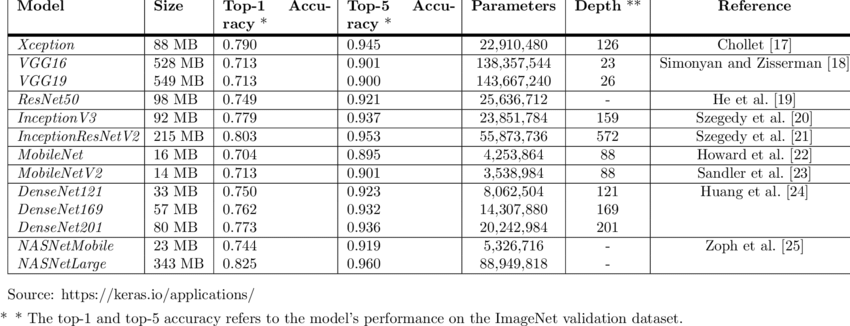

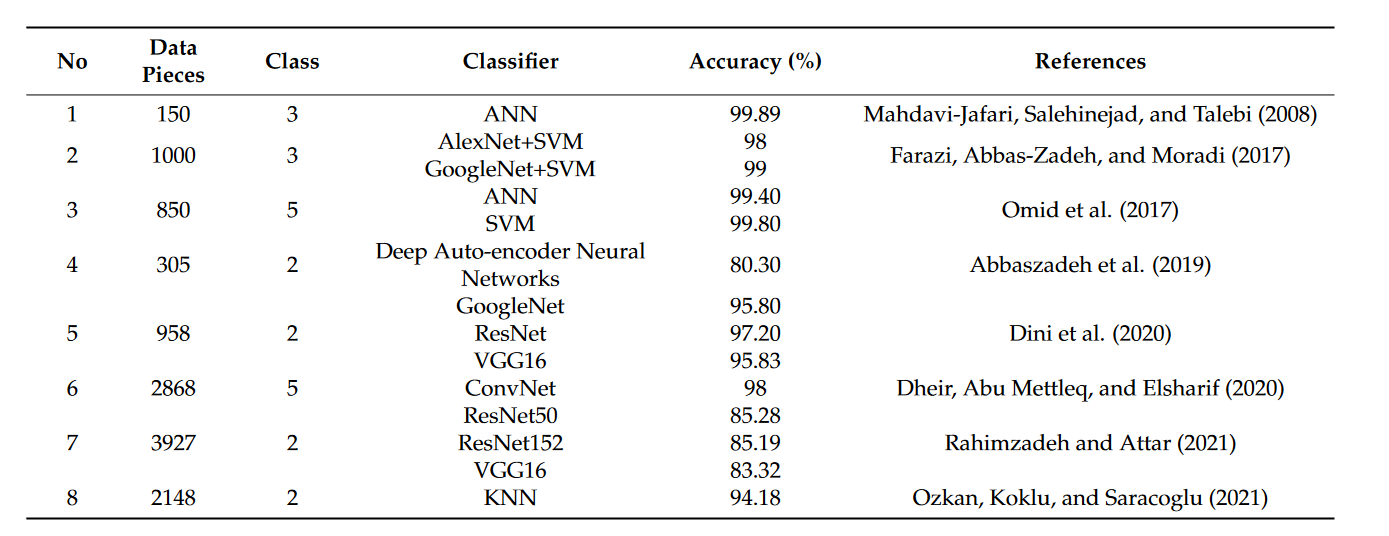

importing neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
import cv2
import matplotlib.pylab as plt

- creating train, valid and test directory :

In [3]:
import random
import shutil
import glob

os.chdir('Pistachio_Image_Dataset')
if os.path.isdir('train/Siirt') is False:
    os.makedirs('train/Kirmizi')
    os.makedirs('valid/Siirt')
    os.makedirs('valid/Kirmizi')
    os.makedirs('test/Siirt')
    os.makedirs('test/Kirmizi')

    for c in random.sample(glob.glob('Siirt_Pistachio/*'), 100):
        shutil.move(c, 'valid/Siirt')
    for c in random.sample(glob.glob('Kirmizi_Pistachio/*'), 100):
        shutil.move(c, 'valid/Kirmizi')
    for c in random.sample(glob.glob('Siirt_Pistachio/*'), 200):
        shutil.move(c, 'test/Siirt')
    for c in random.sample(glob.glob('Kirmizi_Pistachio/*'), 200):
        shutil.move(c, 'test/Kirmizi')
    shutil.move('Siirt_Pistachio', 'train/Siirt')
    shutil.move('Kirmizi_Pistachio', 'train/Kirmizi')

- Preproccessing images :

In [25]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [26]:
train_directory = 'Pistachio_Image_Dataset/train'
valid_directory = 'Pistachio_Image_Dataset/valid'
test_directory = 'Pistachio_Image_Dataset/test'

bs = 32

num_classes = 2

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'Kirmizi', 1: 'Siirt'}


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from torchvision.models import inception_v3
model = inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Rina/.cache\torch\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [07:24<00:00, 245kB/s]  


In [10]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model.softmax = nn.Softmax(dim=1)

In [14]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [17]:
summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [30]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [33]:
model.aux_logits = False

In [34]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_acc = 0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
            
    return model, history

In [50]:
trained_model, history = train_and_validate(model, loss, optimizer, 5)
torch.save(history, 'Pistachio_Image_Dataset'+'_history.pt')

Epoch: 1/5
Epoch : 001, Training: Loss: 0.2752, Accuracy: 88.9535%, 
		Validation : Loss : 0.2321, Accuracy: 92.0000%, Time: 457.7991s
Epoch: 2/5
Epoch : 002, Training: Loss: 0.2809, Accuracy: 88.5659%, 
		Validation : Loss : 0.2339, Accuracy: 93.0000%, Time: 549.2330s
Epoch: 3/5
Epoch : 003, Training: Loss: 0.2762, Accuracy: 88.3075%, 
		Validation : Loss : 0.2359, Accuracy: 91.0000%, Time: 548.6134s
Epoch: 4/5
Epoch : 004, Training: Loss: 0.2361, Accuracy: 90.1809%, 
		Validation : Loss : 0.2513, Accuracy: 91.5000%, Time: 535.4042s
Epoch: 5/5
Epoch : 005, Training: Loss: 0.2683, Accuracy: 89.4703%, 
		Validation : Loss : 0.2182, Accuracy: 92.0000%, Time: 510.5847s


In [47]:
def test(model, test_data_loader, device):
   
    model.eval()

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data and obtain predictions
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
        
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predictions.tolist())

    # Calculate the classification report
    report = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes)
    print(report)

In [49]:
from sklearn.metrics import confusion_matrix
confusion = test(trained_model, test_data_loader, device)
confusion

array([[191,   9],
       [ 36, 164]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(confusion_mat):
    # Extract values from the confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_mat.ravel()

    # Compute performance metrics
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Print the performance metrics
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall (True Positive Rate): {:.4f}".format(recall))
    print("Specificity (True Negative Rate): {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(f1_score))

In [ ]:
calculate_metrics(confusion)

In [37]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

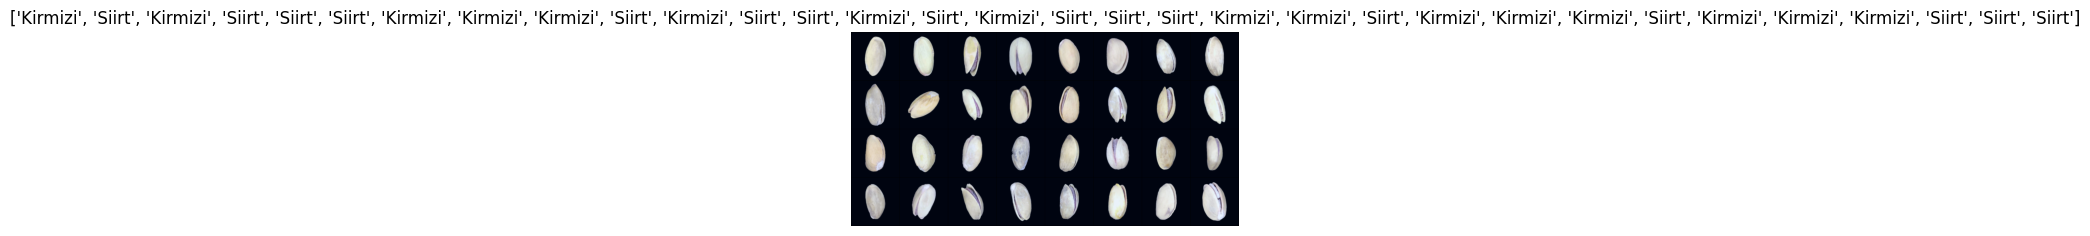

In [40]:
dataiter = iter(DataLoader(data['train'], batch_size=bs, shuffle=True))
images, labels = next(dataiter)

imshow(images, [data['train'].classes[i] for i in labels])


### Second Approach

In [41]:
df = pd.read_excel('Pistachio_16_Features_Dataset.xlsx')

In [42]:
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio


In [10]:
kirmizi_img = glob('Pistachio_Image_Dataset/Kirmizi_Pistachio/*.jpg')
siirt_img = glob('Pistachio_Image_Dataset/Siirt_Pistachio/*.jpg')

In [11]:
img_mpl = plt.imread(kirmizi_img[6])

<function matplotlib.pyplot.show(close=None, block=None)>

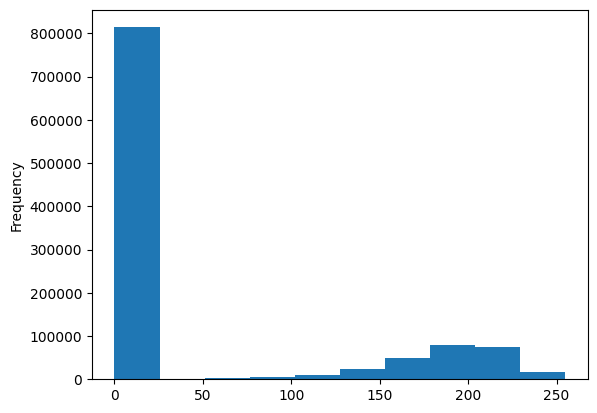

In [12]:
pd.Series(img_mpl.flatten()).plot(kind='hist')
plt.show

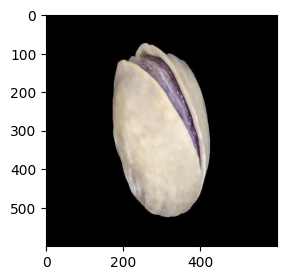

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img_mpl)
plt.show()

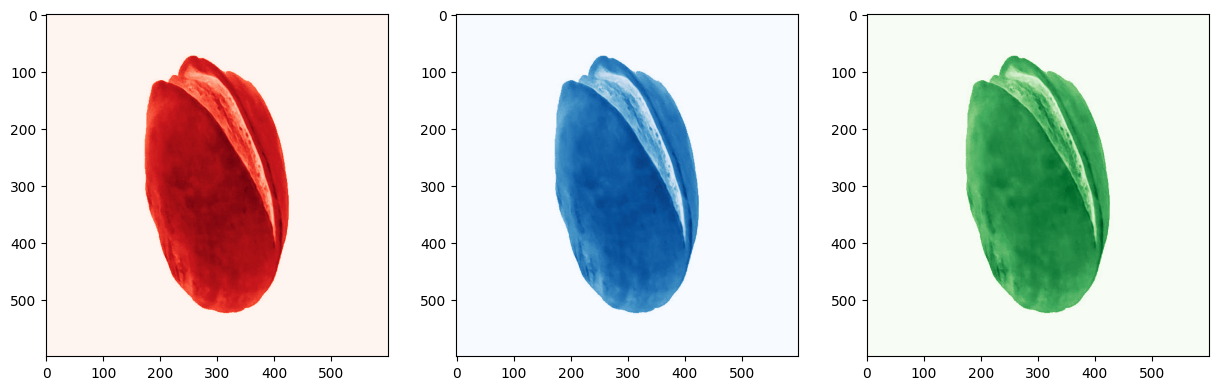

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_mpl[:,:,0], cmap='Reds')
axs[1].imshow(img_mpl[:,:,1], cmap='Blues')
axs[2].imshow(img_mpl[:,:,2], cmap='Greens')
plt.show()